In [48]:
# Libraries
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from scipy.stats import poisson, chi2, chisquare
import matplotlib.pyplot as plt
import seaborn as sns
import this

In [2]:
# Versions
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
#print("statsmodels version:", sm.__version__)

pandas version: 0.25.1
numpy version: 1.17.2


In [3]:
# Directories & Files
os.listdir()

# Datasets directory
directory = "./datasets/"

In [4]:
# Setting the 
datasets = {"five38": "spi_matches.csv", 
            "belgium": "belgium.csv",
            "champions": "champs.csv",
            "deductions": "deductions.csv",
            "eng_club_data": "england_club_data.csv",
            "eng_nonleague": "england_nonleague.csv",
            "england": "england.csv",
            "eng_playoffs": "englandplayoffs.csv",
            "fa_cup": "facup.csv",
            "france": "france.csv",
            "germany": "germany.csv",
            "germany2": "germany2.csv",
            "greece": "greece.csv",
            "holland": "holland.csv",
            "italy": "italy.csv",
            "league_cup_test": "leagucuptest.csv",
            "league_cup": "leaguecup.csv",
            "mls": "mls.csv",
            "mls_conference": "mlsconfs.csv",
            "portugal": "portugal.csv",
            "south_africa": "safrica.csv",
            "scotland": "scotland.csv",
            "turkey": "turkey.csv",
            "team_names": "teamnames.csv",
            "spain": "spain.csv"}

In [5]:
# Creating the DataFrames
for name in datasets:
    print(name)
    globals()[name] = pd.read_csv(directory + datasets[name])
    
#dataframes = {f"{name}": globals()[name] = pd.read_csv(directory + datasets[name]) for name in datasets}

five38
belgium
champions
deductions
eng_club_data
eng_nonleague
england
eng_playoffs
fa_cup
france
germany
germany2
greece
holland
italy
league_cup_test
league_cup
mls
mls_conference
portugal
south_africa
scotland
turkey
team_names
spain


In [6]:
# Cleaning five38
five38.head()

,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
0,2016-08-12,1843,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,32.4,67.7,0.0,1.0,0.97,0.63,0.43,0.45,0.00,1.05
1,2016-08-12,1843,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,53.7,22.9,2.0,2.0,2.45,0.77,1.75,0.42,2.10,2.10
2,2016-08-13,2411,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,2.10,1.05
3,2016-08-13,2411,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,43.6,34.6,0.0,1.0,1.11,0.68,0.84,1.60,0.00,1.05
4,2016-08-13,2411,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,31.9,48.0,1.0,1.0,0.73,1.11,0.88,1.81,1.05,1.05


In [7]:
# reducing five38 to date, league, team1 (Home Team), team2 (Away Team), score1 (Home Goals), 
# score 2 (Away Goals)

five_redux = five38[["date", "league", "team1", "team2", "score1", "score2"]]
five_redux

,date,league,team1,team2,score1,score2
0,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,0.0,1.0
1,2016-08-12,French Ligue 1,AS Monaco,Guingamp,2.0,2.0
2,2016-08-13,Barclays Premier League,Hull City,Leicester City,2.0,1.0
3,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,0.0,1.0
4,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,1.0,1.0
...,...,...,...,...,...,...
34005,2020-11-29,Norwegian Tippeligaen,SK Brann,Aalesund,NaN,NaN
34006,2020-11-29,Norwegian Tippeligaen,Viking FK,Stromsgodset,NaN,NaN
34007,2020-11-29,Norwegian Tippeligaen,Sarpsborg,Rosenborg,NaN,NaN
34008,2020-11-29,Norwegian Tippeligaen,IK Start,Kristiansund BK,NaN,NaN


In [8]:
# checking Series types
five_redux.dtypes

date       object
league     object
team1      object
team2      object
score1    float64
score2    float64
dtype: object

In [9]:
# checking for nulls
print("Nulls:\n", five_redux.isnull().sum())
print()
print("Na's %:\n", five_redux.isna().mean().round(4) * 100)

Nulls:
 date         0
league       0
team1        0
team2        0
score1    3830
score2    3830
dtype: int64

Na's %:
 date       0.00
league     0.00
team1      0.00
team2      0.00
score1    11.26
score2    11.26
dtype: float64


In [10]:
# defining a couple of functions to provide me info about the nulls
def null_cols(ds):
    """check whether the value in each field is missing (null) and return either 
    True or False for each field, totaling up the number of True values by column."""
    return ds.isnull().sum()

def na_cols(ds):
    """Does the same as null_cols, but returns the value as a percentage. 
    Useful to decide where to drop."""
    return ds.isna().mean().round(4) * 100

In [11]:
# creating a dict to map df names to 
dataframes = {"five38_redux": five_redux, 
            "be": belgium,
            "ucl": champions,
            "duducts": deductions,
            "eng_club": eng_club_data,
            "eng_non_league": eng_nonleague,
            "eng": england,
            "england_playoffs": eng_playoffs,
            "cup_fa": fa_cup,
            "fr": france,
            "ger": germany,
            "ger2": germany2,
            "gr": greece,
            "ned": holland,
            "ita": italy,
            "l_cup_test": league_cup_test,
            "l_cup": league_cup,
            "usa": mls,
            "conference": mls_conference,
            "pt": portugal,
            "sa": south_africa,
            "sco": scotland,
            "trkey": turkey,
            "teamnames": team_names,
            "spa": spain}

In [12]:
# checking if the df's have (or not) nulls in them
for name in dataframes:
    print(name, null_cols(dataframes[name]), "\n")

# five38_redux has on score1 and score 2
# ucl has on leg, HT, aet, pens, aethgoal, aetvgoal and tiewinner
# eng_club has on highest_div, col1, col2, short_name, three_letter_name, nicknames
# eng_non_league has on Date
# eng has on division
# england_playoffs has on aet, pen, Venue, attendance, neutral
# cup_fa has on Date, visitor, FT, hgoal, vgoal, tie, aet, pen, pens, hp, vp, Venue, \
# attendance, nonmatch, notes, neutral
# l_cup_test has on aet, pens, Venue, attendance, northsouth
# l_cup has on aet, pens, Venue, attendance, northsouth
# usa has on leg, hgoalaet, vgoalaet, hpen, vpen
# conference has on every col except team
# teamnames has on name_other and most_recent
# spa has on HT, group and notes

# be, duducts Season, fr, ger, ger2, ned, ita, pt, sa, sco, trkey,  don't

five38_redux date         0
league       0
team1        0
team2        0
score1    3830
score2    3830
dtype: int64 

be Unnamed: 0    0
Date          0
Season        0
home          0
visitor       0
FT            0
hgoal         0
vgoal         0
division      0
tier          0
totgoal       0
goaldif       0
result        0
dtype: int64 

ucl Date                 0
Season               0
round                0
leg                 64
home                 0
visitor              0
FT                   0
HT                1705
aet               6428
pens              6351
hgoal                0
vgoal                0
FTagg_home           0
FTagg_visitor        0
aethgoal          6428
aetvgoal          6428
tothgoal             0
totvgoal             0
totagg_home          0
totagg_visitor       0
tiewinner         2186
hcountry             0
vcountry             0
dtype: int64 

duducts Season       0
team         0
tier         0
deduction    0
country      0
dtype: int64 

eng_club t

In [13]:
# looking at nulls characteristics
five_redux[five_redux.isnull().any(axis = 1)]["date"].unique()

array(['2019-11-02', '2019-12-15', '2020-02-09', '2020-02-16',
       '2020-02-22', '2020-02-23', '2020-02-26', '2020-02-27',
       '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02',
       '2020-03-03', '2020-03-04', '2020-03-06', '2020-03-07',
       '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-20', '2020-03-21',
       '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
       '2020-03-27', '2020-03-28', '2020-03-29', '2020-04-02',
       '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
       '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11',
       '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15',
       '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
       '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
       '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27',
       '2020-04-29', '2020-04-30', '2020-05-01', '2020-

In [14]:
# droping all nulls that are from today (26 Feb. 2020) onwards
# AFTER converting dtype to datetime 
five_redux["date"] = pd.to_datetime(five_redux["date"])#, format = "%d/%m/%Y")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# checking if "date" was converted to datetime correctly
five_redux.dtypes

date      datetime64[ns]
league            object
team1             object
team2             object
score1           float64
score2           float64
dtype: object

In [16]:
# so NOW dropping the nulls from this date onwards (it had 3830 in score1 and score 2):
new_five38 = five_redux.loc[(five_redux["date"] < "2020-02-26")]

In [17]:
# now it only has 10 in each column, so we can see them:
new_five38.isna().sum()

# entity 26630 was Postponed, 28235 was Suspended, 29616 was Postponed, 29624 was Postponed,
# 29884 was Postponed, and all the others where postponed due to the Corona Virus Outbreak
# in Italy, so I'll drop them to.
new_five38.loc[five_redux.isnull().any(axis = 1)]

,date,league,team1,team2,score1,score2
26630,2019-11-02,Scottish Premiership,Rangers,St Johnstone,NaN,NaN
28235,2019-12-15,Spanish Segunda Division,Rayo Vallecano,Albacete,NaN,NaN
29616,2020-02-09,Dutch Eredivisie,FC Utrecht,Ajax,NaN,NaN
29624,2020-02-09,Dutch Eredivisie,AZ,Feyenoord,NaN,NaN
29884,2020-02-16,Danish SAS-Ligaen,AGF Aarhus,Randers FC,NaN,NaN
30001,2020-02-22,Italy Serie B,Ascoli,Cremonese,NaN,NaN
30114,2020-02-23,Italy Serie A,Torino,Parma,NaN,NaN
30118,2020-02-23,Italy Serie A,Atalanta,Sassuolo,NaN,NaN
30121,2020-02-23,Italy Serie A,Verona,Cagliari,NaN,NaN
30151,2020-02-23,Italy Serie A,Internazionale,Sampdoria,NaN,NaN


In [18]:
# droping
new_five38.dropna(inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
# checking if they where droped
new_five38.isna().sum()

# comparing the original dataframe to the actual (from: 34010, to: 30180, which is: 3830. 
# so all should be well
print(five38.shape, new_five38.shape)

(34010, 22) (30180, 6)


In [20]:
# rechecking the head
new_five38.head()

,date,league,team1,team2,score1,score2
0,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,0.0,1.0
1,2016-08-12,French Ligue 1,AS Monaco,Guingamp,2.0,2.0
2,2016-08-13,Barclays Premier League,Hull City,Leicester City,2.0,1.0
3,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,0.0,1.0
4,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,1.0,1.0


In [21]:
# chaging the names of the Series
new_five38.rename(columns = {"team1": "home", "team2": "away", 
                             "score1": "home_goals", "score2": "away_goals"}, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [22]:
# checking
new_five38

,date,league,home,away,home_goals,away_goals
0,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,0.0,1.0
1,2016-08-12,French Ligue 1,AS Monaco,Guingamp,2.0,2.0
2,2016-08-13,Barclays Premier League,Hull City,Leicester City,2.0,1.0
3,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,0.0,1.0
4,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,1.0,1.0
...,...,...,...,...,...,...
30185,2020-02-25,English League One,Blackpool,Bolton,2.0,1.0
30186,2020-02-25,English League Championship,Queens Park Rangers,Derby County,2.0,1.0
30187,2020-02-25,UEFA Champions League,Napoli,Barcelona,1.0,1.0
30188,2020-02-25,English League Championship,West Bromwich Albion,Preston North End,2.0,0.0


In [23]:
# adding a new Series, "t_goals", which sums the home and away goals
new_five38["t_goals"] = new_five38["home_goals"] + new_five38["away_goals"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
# checking
new_five38

,date,league,home,away,home_goals,away_goals,t_goals
0,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,0.0,1.0,1.0
1,2016-08-12,French Ligue 1,AS Monaco,Guingamp,2.0,2.0,4.0
2,2016-08-13,Barclays Premier League,Hull City,Leicester City,2.0,1.0,3.0
3,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,0.0,1.0,1.0
4,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,1.0,1.0,2.0
...,...,...,...,...,...,...,...
30185,2020-02-25,English League One,Blackpool,Bolton,2.0,1.0,3.0
30186,2020-02-25,English League Championship,Queens Park Rangers,Derby County,2.0,1.0,3.0
30187,2020-02-25,UEFA Champions League,Napoli,Barcelona,1.0,1.0,2.0
30188,2020-02-25,English League Championship,West Bromwich Albion,Preston North End,2.0,0.0,2.0


In [25]:
# Creating a "season" Series. This one maybe a bit trickier...
new_five38.loc[(five_redux["date"] > "2019-07-01") & (five_redux["date"] < "2020-07-01") &
               (five_redux["league"] != "Major League Soccer") | 
               (five_redux["league"] != "United Soccer League")]

,date,league,home,away,home_goals,away_goals,t_goals
0,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,0.0,1.0,1.0
1,2016-08-12,French Ligue 1,AS Monaco,Guingamp,2.0,2.0,4.0
2,2016-08-13,Barclays Premier League,Hull City,Leicester City,2.0,1.0,3.0
3,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,0.0,1.0,1.0
4,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,1.0,1.0,2.0
...,...,...,...,...,...,...,...
30185,2020-02-25,English League One,Blackpool,Bolton,2.0,1.0,3.0
30186,2020-02-25,English League Championship,Queens Park Rangers,Derby County,2.0,1.0,3.0
30187,2020-02-25,UEFA Champions League,Napoli,Barcelona,1.0,1.0,2.0
30188,2020-02-25,English League Championship,West Bromwich Albion,Preston North End,2.0,0.0,2.0


In [26]:
portugal

,Unnamed: 0,Date,Season,home,visitor,FT,hgoal,vgoal,division,tier,totgoal,goaldif,result
0,1,1994-08-20,1994,Farense,Sp Lisbon,0-2,0,2,P1,1,2,-2,A
1,2,1994-08-21,1994,Belenenses,Est Amadora,0-0,0,0,P1,1,0,0,D
2,3,1994-08-21,1994,Benfica,Beira Mar,2-0,2,0,P1,1,2,2,H
3,4,1994-08-21,1994,Desp. Chaves,Salgueiros,0-1,0,1,P1,1,1,-1,A
4,5,1994-08-21,1994,Gil Vicente,Tirsense,0-1,0,1,P1,1,1,-1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,6506,2017-05-20,2016,Rio Ave,Belenenses,2-0,2,0,P1,1,2,2,H
6506,6507,2017-05-21,2016,Estoril,Arouca,4-2,4,2,P1,1,6,2,H
6507,6508,2017-05-21,2016,Moreirense,Porto,3-1,3,1,P1,1,4,2,H
6508,6509,2017-05-21,2016,Sp Lisbon,Chaves,4-1,4,1,P1,1,5,3,H


In [27]:
# checking summary stats again
round(new_five38.describe(), 2)

,home_goals,away_goals,t_goals
count,30180.00,30180.00,30180.00
mean,1.53,1.17,2.70
std,1.28,1.13,1.66
min,0.00,0.00,0.00
25%,1.00,0.00,1.00
50%,1.00,1.00,3.00
75%,2.00,2.00,4.00
max,10.00,9.00,12.00


In [28]:
# checking the max goals
new_five38.loc[new_five38["t_goals"] == new_five38["t_goals"].max()]
new_five38.loc[new_five38["home_goals"] == new_five38["home_goals"].max()]
new_five38.loc[new_five38["away_goals"] == new_five38["away_goals"].max()]

,date,league,home,away,home_goals,away_goals,t_goals
26231,2019-10-25,Barclays Premier League,Southampton,Leicester City,0.0,9.0,9.0


In [29]:
## EDA
new_five38.columns

Index(['date', 'league', 'home', 'away', 'home_goals', 'away_goals',
       't_goals'],
      dtype='object')

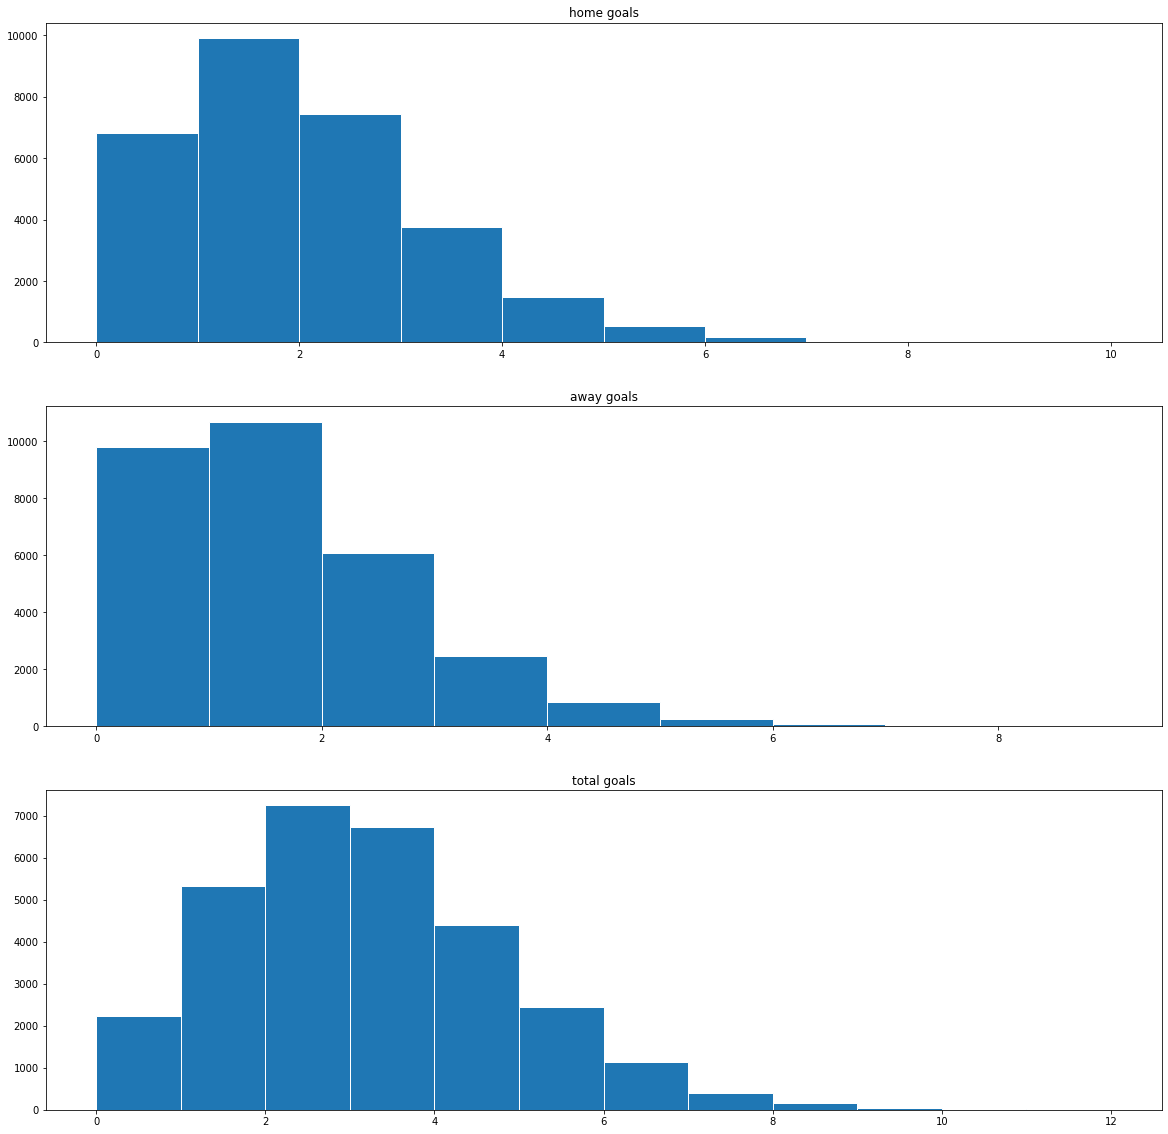

In [30]:
# looking at the distribuition of the data
# staging the figure area and arranging the plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (20, 20))

# preparing the first plot
ax1.hist(new_five38["home_goals"], bins = 10, edgecolor = "white")
ax1.set_title("home goals")

# the second plot
ax2.hist(new_five38["away_goals"], bins = 9, edgecolor = "white")
ax2.set_title("away goals")

# and the third
ax3.hist(new_five38["t_goals"], bins = 12, edgecolor = "white")
ax3.set_title("total goals")

# setting the bkg color to white (in case of export: https://stackoverflow.com/questions/4804005/matplotlib-figure-facecolor-background-color)
fig.set_facecolor("white")
plt.show()

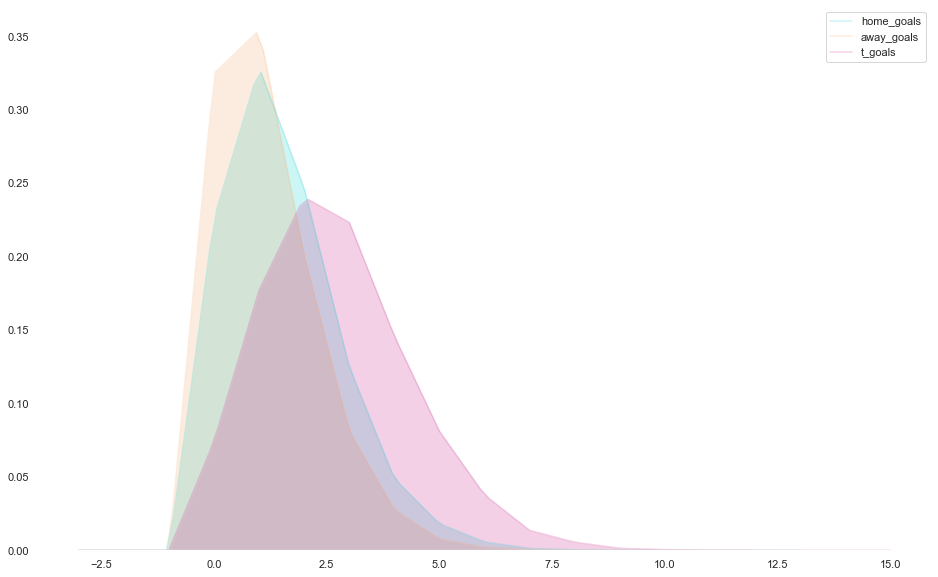

In [31]:
# looking at the distribuition of the data w/
# creating a Density plot

plt.figure(figsize = (16, 10))
sns.set(rc = {"axes.facecolor": "white", "figure.facecolor": "grey"})

p1 = sns.kdeplot(new_five38["home_goals"], shade = True, kernel = "tri", alpha = 0.20, 
                 bw = 1, color = "darkturquoise")
p1 = sns.kdeplot(new_five38["away_goals"], shade = True, kernel = "tri", alpha = 0.20, 
                 bw = 1, color = "sandybrown")
p1 = sns.kdeplot(new_five38["t_goals"], shade = True, kernel = "tri", alpha = 0.20, 
                 bw = 1, color = "mediumvioletred")

In [32]:
# Inferential Statistics..?

In [40]:
# Calculate a few first moments(??)

# Home Goals
home_mu = new_five38["home_goals"].mean()
home_mean, home_var, home_skew, home_kurt = poisson.stats(home_mu, moments = "mvsk")

# Away Goals
away_mu = new_five38["away_goals"].mean()
away_mean, away_var, away_skew, away_kurt = poisson.stats(away_mu, moments = "mvsk")

# Total Goals
t_mu = new_five38["t_goals"].mean()
t_mean, t_var, t_skew, t_kurt = poisson.stats(t_mu, moments = "mvsk")

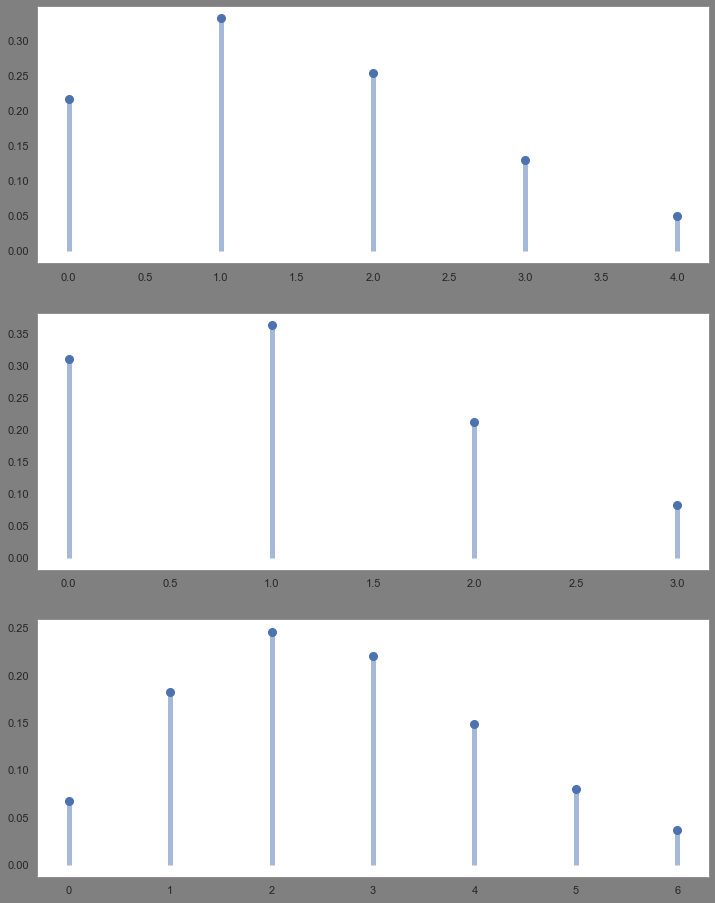

In [45]:
# Display the probability mass function (pmf):
fig, (axhome, axaway, axt) = plt.subplots(3, 1, figsize = (12, 16))

# Home Goals
home_x = np.arange(poisson.ppf(0.01, home_mu), poisson.ppf(0.99, home_mu))
axhome.plot(home_x, poisson.pmf(home_x, home_mu), "bo", ms = 8, 
            label = "Home Goals poisson pmf")
axhome.vlines(home_x, 0, poisson.pmf(home_x, home_mu), colors = "b", lw = 5, alpha = 0.5)

# Away Goals
away_x = np.arange(poisson.ppf(0.01, away_mu), poisson.ppf(0.99, away_mu))
axaway.plot(away_x, poisson.pmf(away_x, away_mu), "bo", ms = 8, 
            label = "Away Goals poisson pmf")
axaway.vlines(away_x, 0, poisson.pmf(away_x, away_mu), colors = "b", lw = 5, alpha = 0.5)

# Total Goals
t_x = np.arange(poisson.ppf(0.01, t_mu), poisson.ppf(0.99, t_mu))
axt.plot(t_x, poisson.pmf(t_x, t_mu), "bo", ms = 8, label = "Total Goals poisson pmf")
axt.vlines(t_x, 0, poisson.pmf(t_x, t_mu), colors = "b", lw = 5, alpha = 0.5)

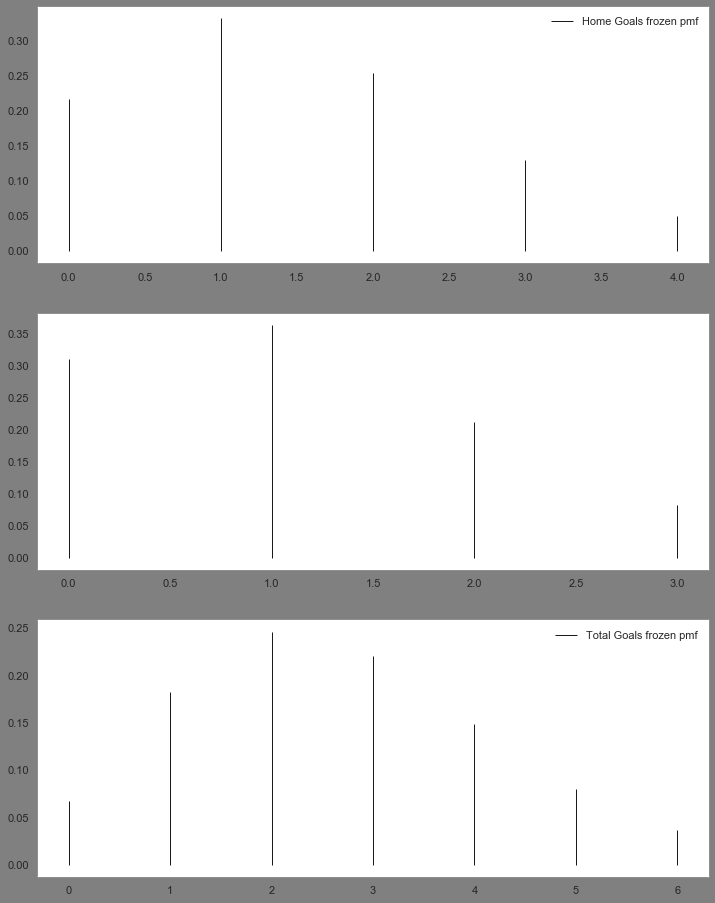

In [46]:
# Freeze the distribution and display the frozen pmf:
fig, (axhome, axaway, axt) = plt.subplots(3, 1, figsize = (12, 16))

# Home Goals
home_rv = poisson(home_mu)
axhome.vlines(home_x, 0, home_rv.pmf(home_x), colors = 'k' , linestyles = "-", lw = 1, 
          label = "Home Goals frozen pmf")
axhome.legend(loc = "best", frameon = False)

# Away Goals
away_rv = poisson(away_mu)
axaway.vlines(away_x, 0, away_rv.pmf(away_x), colors = 'k' , linestyles = "-", lw = 1, 
          label = "Away Goals frozen pmf")
axhome.legend(loc = "best", frameon = False)

# Total Goals
t_rv = poisson(t_mu)
axt.vlines(t_x, 0, t_rv.pmf(t_x), colors = 'k' , linestyles = "-", lw = 1, 
           label = "Total Goals frozen pmf")
axt.legend(loc = "best", frameon = False)

plt.show()

In [47]:
#Check accuracy of cdf and ppf:
home_prob = poisson.cdf(home_x, home_mu)
away_prob = poisson.cdf(away_x, away_mu)
t_prob = poisson.cdf(t_x, t_mu)

# Return Results:
print(f"Home Goals Accuracy of cdf and ppf: {np.allclose(home_x, poisson.ppf(home_prob, home_mu))}\nAway Goals Accuracy of cdf and ppf: {np.allclose(away_x, poisson.ppf(away_prob, away_mu))}\nTotal Goals Accuracy of cdf and ppf: {np.allclose(t_x, poisson.ppf(t_prob, t_mu))}")

Home Goals Accuracy of cdf and ppf: True
Away Goals Accuracy of cdf and ppf: True
Total Goals Accuracy of cdf and ppf: True


In [50]:
# Chi2 test(s?) functions..?

def getBins(xmin,xmax,n_bins):
    """
    I copied from: 
    https://stats.stackexchange.com/questions/202617/implementing-chi-square-in-python-and-testing-on-scipys-poisson-and-norm-variat
    I actully have no idea what it's doing.
    """
    r = np.linspace(xmin,xmax,num = n_bins + 1, endpoint = True)
    r = r + 10 ** (-10) # including rightmost
    r[0] = r[0] - 2 * 10 ** (-10) # excluding xmin from (-Inf;xmin] bin
    return np.concatenate((np.array([float('-inf')]), r, np.array([float('inf')])))

# Calculates probabilities for each bin (a,b] within given cumulative distribution function 
def piCalcDecoratorNew(bins, *args):
    def real_piCalcDecorator(cdfFunc):
        def piCalc(*args):
            piA = np.zeros(len(bins) - 1)
            if len(args) == 1:
                args = args[0]
                piA[0] = cdfFunc(bins[1], args)  
                piA[-1] = 1 - cdfFunc(bins[-2], args)
                for i in range(1, len(bins) - 2):
                    piA[i] = cdfFunc(bins[i + 1], args) - cdfFunc(bins[i], args)
            else: #number of params >1
                piA[0] = cdfFunc(bins[1], *args)            
                piA[-1] = 1 - cdfFunc(bins[-2], *args)
                for i in range(1, len(bins) -2):
                    piA[i] = cdfFunc(bins[i + 1], *args) - cdfFunc(bins[i], *args)
            return piA  
        return piCalc
    return real_piCalcDecorator

# similar to scipy's chisquare()
def chi2statistic(obs = np.array([16, 18, 16, 14, 12, 12], dtype = 'float'), 
                  exp = np.array([16, 16, 16, 16, 16, 8], dtype = 'float')):
    temp = np.square(obs - exp, dtype = 'float')
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        temp = temp / exp
        temp[exp == 0] = 0
    return sum(temp)
    # like return chisquare(obs, exp)

def chi2test(df, x, alpha, cdfFunc, *args):
    N = len(x)
    xmin = min(x)
    xmax = max(x)
    bins = getBins(xmin, xmax, df - 2)
    print("Bins for histogram are ")
    print(bins)
    piCalc = piCalcDecoratorNew(bins, *args)(cdfFunc)
    piks = piCalc( *args)
    print("Expected probability to be in a bin")
    print(piks)
    a = piks * float(N)
    b = np.histogram(x, bins)[0]
    print("Observed probabilities for bins")
    print(b / float(N))
    print("Chi2 statistic is {0}".format(chi2statistic(b,a)))
    print("Critical value is {0}".format(chi2.ppf(alpha,df)))
    return (chi2statistic(b,a),chi2.ppf(alpha,df))